# Loitering Application

**Make Sure to switch runtime accelerator to GPU**
> Menu -> Runtime -> Change runtime type -> Hardware accelerator -> GPU 

This notebook utilized google colab for code execution and git for version control

> Please clone the [repo](https://gitlab.com/deepmentor.ai/sandbox/loitering.git) using git to your google drive and open this notebook with colab

**Function** :
* When a person enter a user defined alarmzone about 5 second in playback video program will trigger alarm
* Alarm will reset after triggered 

## Setting Colab Environment

1.Mount to your google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2. Change directory to git repo in drive

In [2]:
%cd /content/drive/MyDrive/loitering

/content/drive/MyDrive/loitering


3. Pull from repo

In [3]:
#pull from branch
!git pull 

From https://gitlab.com/deepmentor.ai/sandbox/loitering
 * branch            branch_sam -> FETCH_HEAD
Already up to date.


4. Install Python Packages

In [4]:
!pip3 install deep_sort_realtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 69.9 MB/s eta 0:00:00


5. Test yolov7 inference

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block


/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


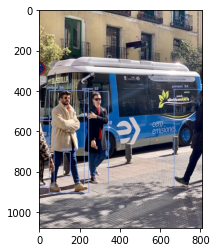

In [5]:
import cv2
import numpy as np
from loitering.detect import Yolov7_Detector
from matplotlib import pyplot as plt
%matplotlib inline
class_names=np.load("./loitering/yolov7_quick_start/coco_80class.npy")
# Function to draw bounding box on the detected object with class name
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(class_names[int(class_id)])

    color = COLORS[int(class_id)]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label+' '+str(int(confidence)), (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
# Generate different colors for different classes 
COLORS = np.random.uniform(0, 255, size=(len(class_names), 3))

# Load data
img_pth = "./loitering/yolov7_quick_start/test_imgs/bus.jpg"
image = cv2.imread(img_pth)

# Generate different colors for different classes 
COLORS = np.random.uniform(0, 255, size=(len(class_names), 3))

# Construct Detector Class   
# inference device: for cuda device specify the device id 'cuda:0'  for CPU 'cpu'
yolov7=Yolov7_Detector(inference_device="cpu")
yolov7.load_model()
# Predict
pred = yolov7.detect(image)
# Visulaize Result
for x1, y1, x2, y2, conf, class_id in pred:
    draw_bounding_box(image,int(class_id),int(conf*100),int(x1),int(y1),int(x2),int(y2))
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

## Run Application

1. import python packages and scripts

In [6]:
# import python packages
import cv2
import torch
import numpy as np
from deep_sort_realtime.deepsort_tracker import DeepSort
# import scripts
from loitering.detect import Yolov7_Detector
from loitering.utils import *

2. Prepare Yolov7 Model for inference

In [7]:
#Load COCO default 80 class namess
class_names=np.load("./loitering/yolov7_quick_start/coco_80class.npy")
#Check CUDA Device availibility and set inference device
if(torch.cuda.is_available()):
    device='cuda:0'
    print('Using GPU for inference')
else:
    device='cpu'
    print('Using CPU for inference')
#Load pretrained weights for yolov7 (COCO DataSet) and set inference setting
yolov7=Yolov7_Detector(weight_pth='./loitering/yolov7_quick_start/weights/yolov7-e6.pt',inference_device=device
                                                                    ,img_size=640,conf_thresh=0.3,iou_thresh=0.35)
yolov7.load_model()

Using GPU for inference
Fusing layers... 


3. Prepare input data for inference

In [8]:
#Read  User defined Loitering alarm zone annotation file(COCO format)
alarm_vertices=alarmzone_anno_reader('./loitering/annotations/alarmzone1.json')
print("Vertices of alarmzone:")
print(alarm_vertices)
# Read video file with opencv
cap=cv2.VideoCapture('./test_video/raw_loitering.mp4')
# check if the video file was opened successfully
if not cap.isOpened():
    print("Error opening video file")
else:
    # Get the frames per second (FPS) of the video
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    print(f"Loaded Input Video :")
    print(f'FPS: {fps}')
    print(f'Resolution: {width} x {height}')


# Intialize DeepSort Tracker
tracker = DeepSort(max_age=int(fps))

# Set up the output video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # or other codec
out = cv2.VideoWriter('./result/output_video.mp4', fourcc, fps, (width, height))

Vertices of alarmzone:
[[140 339]
 [579 719]
 [922 719]
 [781 369]
 [365 208]]
Loaded Input Video :
FPS: 25
Resolution: 1280 x 720


4. Start Inference and Detect Loitering

In [9]:
# Variables Initialization
frame_counter = 0 # reset to 0 when frame_counter == fps
video_sec = 0 # video time in second
no_of_person = 0 # number of people in zone
loitering_t = 0 # loitering time
flag = 0 # if flag == 1 person detected in alarmzone for that second

# Start processing
while cap.isOpened():# Loop over video frames
    # read the next frame from the video file
    ret, frame = cap.read()
    # check if the frame was read successfully
    if not ret:
        break
    # copy the frame for processing
    input = frame.copy()
    no_of_person=0
    frame_counter += 1
    # Human Detection with Yolov7
    pred=yolov7.detect(input)
    # Draw the polygon on the image
    cv2.polylines(input, [alarm_vertices], True, (0, 255, 255), 2)
    
    # detections expected to be a list of detections, each in tuples of ( [left,top,w,h], confidence, detection_class )
    detections = [([ x1 , y1, x2 - x1, y2 - y1], conf, 0) for x1, y1, x2, y2, conf, class_id in pred if class_id == 0]
    
    # Start tracking
    tracks = tracker.update_tracks(detections, frame=frame) 
    if(tracks is not None):
         for track in tracks:
            if not track.is_confirmed():
                continue
            person_id = track.track_id
            ltrb = track.to_ltrb()
            bb_cent=( int((ltrb[0]+ltrb[2])/2) , int((ltrb[1]+ltrb[3])/2) ) # compute bounding box center
            # Using point in polygon algorithm to detect whether target bounding box center is in alarm zone
            test_res=point_polygon_tester(bb_cent,alarm_vertices)
            # draw bounding box
            bounding_box_drawer_track(input,person_id,int(ltrb[0]),int(ltrb[1]),int(ltrb[2]),int(ltrb[3]),test_res)
            if(test_res):
                no_of_person += 1
                if(flag==0):
                    flag=1

                
    # For visulaization
    cv2.putText(input,f"Video Seconds: {video_sec}", (30,30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)
    cv2.putText(input,f"Number of target: {no_of_person}", (30,60), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

    if(frame_counter == fps):# if all frame in 1 second has been processed
        frame_counter=0
        video_sec+=1
        if(flag):
            loitering_t += 1
        # Person in alarm zone for 5 second 
        if(loitering_t == 5):
            print(f'Trigger loitering at {video_sec} sceond')
            # reset alarm
            loitering_t = 0
        # reset flag every second
        flag = 0
    # write the processed frame to video writer for visualization
    out.write(input)

Trigger loitering at 5 sceond
Trigger loitering at 13 sceond
Trigger loitering at 18 sceond
Trigger loitering at 23 sceond
Trigger loitering at 28 sceond
Trigger loitering at 33 sceond
Trigger loitering at 38 sceond
Trigger loitering at 43 sceond
Trigger loitering at 48 sceond
Trigger loitering at 53 sceond


5. Release video file and check the result
> Default path of output video is in the './result' folder

In [ ]:
# release the video file
cap.release()
out.release()